In [1]:
import re
import glob
from datetime import datetime

import math
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString

import movingpandas as mpd
from movingpandas.trajectory_smoother import KalmanSmootherCV

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore", message="CRS not set for some of the concatenation inputs.")

In [7]:
def _build_usbl_gdf(site_gpkg, datetime_field='DateTime', pdop_field=None, filter_quartile=0.95) -> gpd.GeoDataFrame:
    """
    Given a path to a geospatial vector point file (e.g. shapefile, geopackage, etc),
    read the file into a GeoPandas GeoDataFrame and optionally filter outliers based
    on a precision (PDOP) field.
    """
    # read USBL data into GeoPandas
    usbl_gdf = site_gpkg.copy()

    # filter outliers by keeping lower quartile of PDOP values
    if pdop_field is not None:
        max_pdop = usbl_gdf[pdop_field].quantile(filter_quartile)
        print(type(max_pdop), max_pdop)

        if not math.isnan(max_pdop):
            count = len(usbl_gdf) - len(usbl_gdf[usbl_gdf[pdop_field] < max_pdop])
            usbl_gdf = usbl_gdf[usbl_gdf[pdop_field] < max_pdop]

            print(f"--filter_quartile of {filter_quartile} allows a max PDOP of {max_pdop}.")
            print(f"{count} USBL pings were filtered based on their {pdop_field} field.")
        else:
            print(f"WARNING: No valid PDOP values found in column {pdop_field}. No filtering will be performed.")
    else:
        print("WARNING: No PDOP field specified. No filtering will be performed.")

    # standardize the datetime field, and set that as the index
    # usbl_gdf["datetime_idx"] = usbl_gdf[datetime_field].apply(
    #     lambda x: datetime.strptime(re.sub('[/.:]', '-', x), '%Y-%m-%d %H-%M-%S')
    # )
    # usbl_gdf.index = usbl_gdf['datetime_idx']
    usbl_gdf.index = usbl_gdf['DateTime']

    return usbl_gdf


def _calc_trajectory(pt_gdf, process_noise_std=1.0, measurement_noise_std=0.25):
    """
    Given a GeoPandas GeoDataFrame of points, calculate the trajectory with
    MovingPandas. Optionally smooth the trajectory with a Kalman filter.
    """
    # calculate trajectory information with MovingPandas
    traj = mpd.Trajectory(pt_gdf, 1, t="datetime_idx", crs=pt_gdf.crs)

    # Smooth trajectories... smoothing is skipped if either std is equal to 0.0
    if process_noise_std != 0.0 or measurement_noise_std != 0.0:
        traj = KalmanSmootherCV(traj).smooth(
            process_noise_std=process_noise_std,
            measurement_noise_std=measurement_noise_std)
    else:
        print(f"Either process_noise_std or measurement_noise_std is set to 0.0, \
            therefore no smoothing will be applied to trackline.")

    traj.add_direction(overwrite=True, name="Direction")
    traj.add_speed(overwrite=True, name="Speed")
    # s_traj.add_acceleration(overwrite=True, name="Acceleration")
    traj.add_distance(overwrite=True, name="Distance")
    # s_traj.add_timedelta(overwrite=True, name="TimeDelta")

    return traj


def global_rotation(site_gpkg, output_folder=None, datetime_field="DateTime",
                    pdop_field=None, filter_quartile=0.95, process_noise_std=1.0,
                    measurement_noise_std=0.25, reversed=False) -> float:
    """
    Given a GeoPandas GeoDataFrame of points, use the XY coordinates and
    datetime stamps to calculate a trajectory and derive the global rotation
    angle (direction). The direction is given in degrees, clockwise from North.
    """
    # Build the geodataframe from usbl
    pt_gdf = _build_usbl_gdf(
        site_gpkg,
        datetime_field=datetime_field,
        pdop_field=pdop_field,
        filter_quartile=filter_quartile,
    )
    # Get the trajectory
    trajectory = _calc_trajectory(
        pt_gdf,
        process_noise_std=process_noise_std,
        measurement_noise_std=measurement_noise_std,
    )

    # Get the direction
    direction = trajectory.get_direction()
    start = trajectory.get_start_location()
    end = trajectory.get_end_location()

    print(f"Start: {start}\nEnd: {end}")

    # Reverse if needed
    if reversed:
        start, end = end, start
        direction -= 180

    # Create a direction line, given the start and end points
    direction_line = LineString([start, end])
    dirline_gdf = gpd.GeoDataFrame(geometry=[direction_line], crs=pt_gdf.crs)

    # plot the outputs
    f, ax = plt.subplots()
    trajectory.to_line_gdf().plot(ax=ax)
    dirline_gdf.plot(ax=ax, color="red")
    f.legend(["Trajectory", "Direction"])
    plt.scatter(start.x, start.y, c='green', s=20)
    plt.scatter(end.x, end.y, c='red', s=20)
    plt.title(f"Trajectory / Direction: {str(np.deg2rad(direction))}")

    # Save if needed
    if output_folder:
        plt.savefig(f"{output_folder}Direction.png")

    plt.show()

    return np.deg2rad(direction)

In [12]:
site_centroids = glob.glob("B://Drop_e/Testing/**/image_centroids.gpkg", recursive=True)

<class 'numpy.float64'> 3.8395323407333333
--filter_quartile of 0.95 allows a max PDOP of 3.8395323407333333.
4 USBL pings were filtered based on their CaAltCor_m field.
Start: POINT (264975.05437002226 1502294.3902235774)
End: POINT (264966.8481213227 1502277.6062111533)


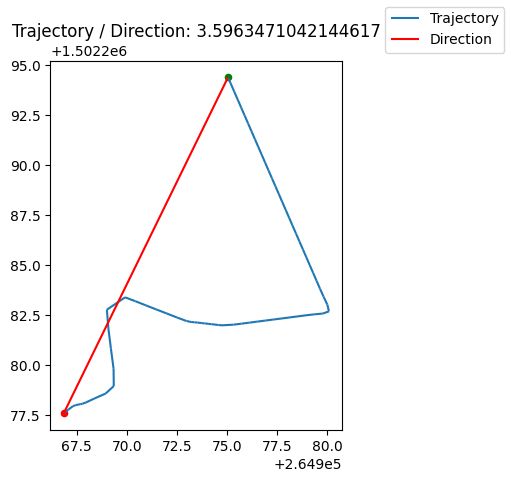

<class 'numpy.float64'> 1.4290622985729167
--filter_quartile of 0.95 allows a max PDOP of 1.4290622985729167.
7 USBL pings were filtered based on their CaAltCor_m field.
Start: POINT (247047.0703793964 1488698.9468481166)
End: POINT (246977.98873132176 1488674.1517429445)


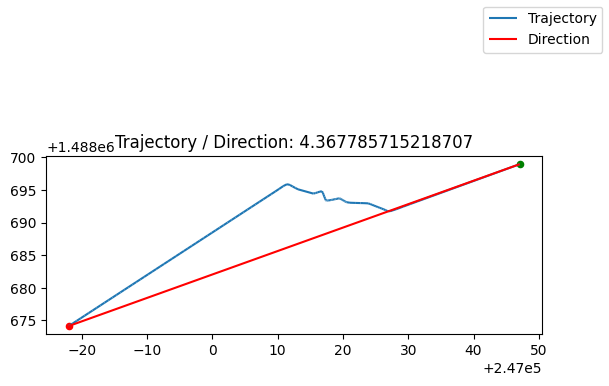

In [19]:
for site_centroid in site_centroids:
    site_gpkg = gpd.read_file(site_centroid)
    rot = global_rotation(site_gpkg, pdop_field="CaAltCor_m")

In [20]:
np.rad2deg(rot)

250.2556872995616